# Class Activation Map (CAM)
Deep Learning is often called "black box" as we could not look inside to understand how and why the network choose the result.
It's not completly true as we will see.
The goal here is to show on the image which area is responsible of the classification choice of the model.
That's what we call Class Activation Map.
We will continue to use our custom dataset of Aibus A380 vs Boeing 747.

The code is inpired by the one from https://github.com/TheShadow29/FAI-notes/blob/master/notebooks/Using-CAM-for-CNN-Visualization.ipynb who made it for Resnet34.
Here we will use it with Resnext50.

To compute the CAM, we will replace some layers at the end and write a callback to save the "features" where the model find interesting area.

Say thanks in 
http://forums.fast.ai/t/using-class-activation-maps-cam-for-visualization/18864



In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import modules
!rm -r {PATH}tmp
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.transform as skt
from sklearn.metrics import confusion_matrix
from fastai.conv_learner import *
from fastai.model import *
from fastai.plots import *
import numpy as np
PATH = "../../datasets/boeing_vs_airbus/"
arch = resnext50

rm: cannot remove '{PATH}tmp': No such file or directory


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# We load the model and the weigths we have trained before
tfms = tfms_from_model(arch, 300)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
#learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
#learn.load("resnext506_bestmodel")
#learn.precompute=True
#print("Model chargé")
#classes = ["A380", "B747"]


Model chargé


In [4]:
# We remove the last three layer, after the last resnext block.
# And add a convolutional layer that took the output of this last block.
layer_to_remove_from = -3
original_model = arch(True)
cam_model = nn.Sequential(*children(original_model)[:layer_to_remove_from], 
                  nn.Conv2d(2048, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1),
                  Flatten(), 
                  nn.LogSoftmax())

len(original_model)
len(cam_model)
#original_model[-3]
#cam_model[-4]

11

12

In [5]:
#learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 300, 300]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [6]:
i=0
for i in range(8, len(original_model)):
    print("layer",i,original_model[i])
    i+=1

layer 0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
layer 1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
layer 2 ReLU()
layer 3 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
layer 4 Sequential(
  (0): Sequential(
    (0): LambdaMap(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (5): ReLU()
        )
        (1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False

In [7]:
i=0
for i in range(8, len(cam_model)):
    print("layer",i,cam_model[i])
    i+=1

layer 0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
layer 1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
layer 2 ReLU()
layer 3 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
layer 4 Sequential(
  (0): Sequential(
    (0): LambdaMap(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (5): ReLU()
        )
        (1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False

In [8]:
# Define training parameters
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, 300, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=100, num_workers=num_cpus())

cam_model = to_gpu(cam_model)
learn = ConvLearner.from_model_data(cam_model, data)
#learn.summary()
learn.ps = [0.25,0.5]


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 300, 300]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 75

In [9]:
# We freeze the weight up to the 6th layer as they have already be trained
learn.freeze_to(-6)
learn.fit(1e-3, 5, cycle_len=1, cycle_mult=2, best_save_name=arch.__name__ + "-heat1_bestmodel")
learn.fit(1e-3, 5, cycle_len=1, cycle_mult=2, best_save_name=arch.__name__ + "-heat2_bestmodel")


epoch      trn_loss   val_loss   accuracy                  
    0      0.685311   0.663446   0.614887  
    1      0.673428   0.677762   0.572816                  
    2      0.629726   0.539499   0.734628                  
    3      0.609071   0.638708   0.656958                  
    4      0.546882   0.37404    0.831715                  
    5      0.465795   0.348328   0.857605                  
    6      0.40662    0.350448   0.854369                  
    7      0.382928   0.437548   0.79288                   
    8      0.329323   0.261395   0.899676                  
    9      0.282024   0.253262   0.886731                  
    10     0.231811   0.238041   0.893204                  
    11     0.192619   0.228197   0.912621                  
    12     0.160234   0.22329    0.915858                  
    13     0.136558   0.240987   0.893204                  
    14     0.115101   0.238156   0.89644                   
    15     0.10177    0.252238   0.87055                

[array([0.20842]), 0.9320388418956868]

## Prediction with CAM
Now that we have trained the layers we have added to the model we could use it to make a prediction

In [10]:
# Remove data augmentation
tfms = tfms_from_model(arch, 300)
# Reduce the batch size to be more practical
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
# Load the best weights we compute
learn.load("resnext50-heat_bestmodel")

Conv2d(2048, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [13]:
# Get the model
cam_model = learn.model
# This class will be used to save the features
class SaveFeatures:
    def __init__(self, m):
        self.handle = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, m, inp, outp):
        self.features = outp
    def remove(self):
        self.handle.remove()

# Save the features of the layer 8, the convolution we have added
sf = [SaveFeatures(ml) for ml in [cam_model[8]]]

In [14]:
# Get the input data, the prediction, and the CAM areas for a batch size in the training set
# and display them
def show_CAM(model, images, classes):
    # Make the prediction on the batch
    log_prob = model(to_gpu(V(images)))
    # Denormalize the input of the batch
    x1 = data.val_ds.denorm(images)
    f = plt.figure(figsize=(16,8))
    rows=2
    for idx in range(len(x1)):
        # Get the activation of one image
        fts = sf[0].features[idx]
        prob = np.exp(to_np(log_prob))
        preds = np.argmax(prob[idx])
        fts_np = to_np(fts)
        f2=np.dot(np.rollaxis(fts_np,0,3), prob[idx])
        f2-=f2.min()
        f2/=f2.max()
        f2
        sp = f.add_subplot(rows, len(x1)//rows, idx+1)
        sp.axis('Off')
        sp.set_title(classes[preds], fontsize=12)
        plt.imshow(x1[idx])
        plt.imshow(scipy.misc.imresize(f2, x1[idx].shape), alpha=0.5, cmap='jet');
        #plt.imshow(skt.resize(f2, x1[idx].shape), alpha=0.5, cmap='hot');
    plt.show();

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


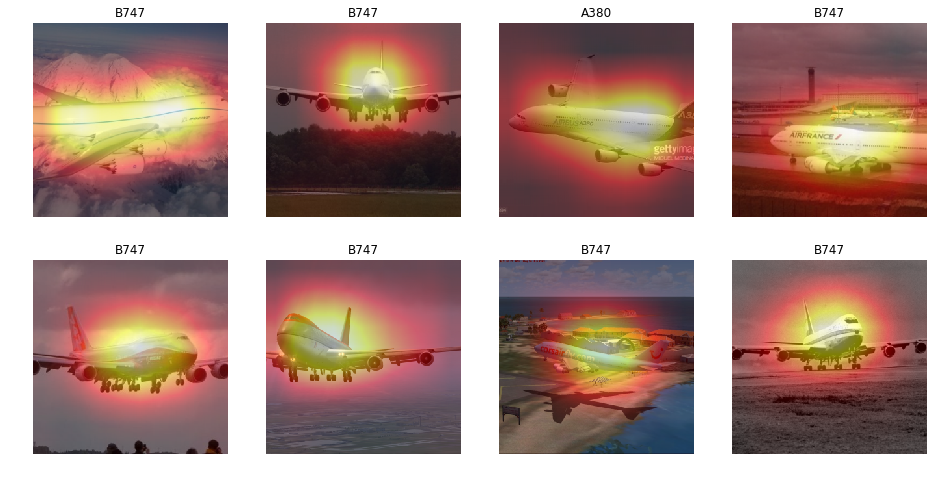

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


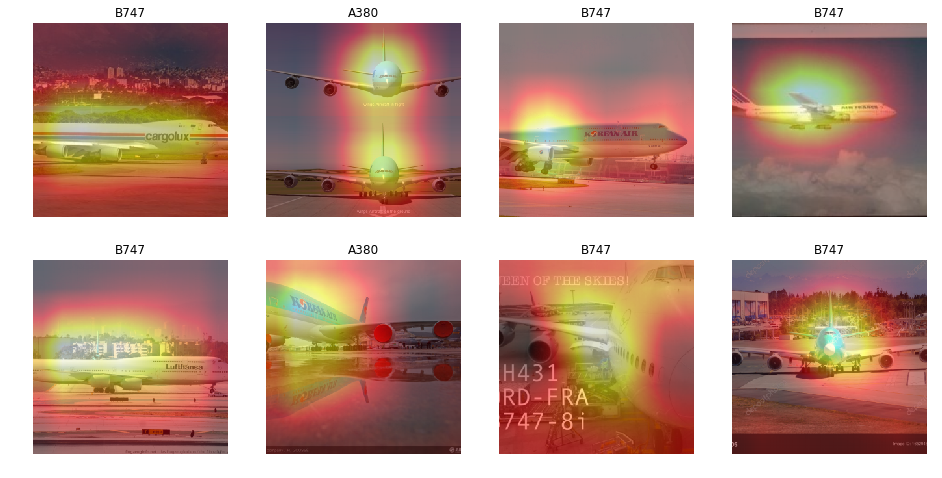

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


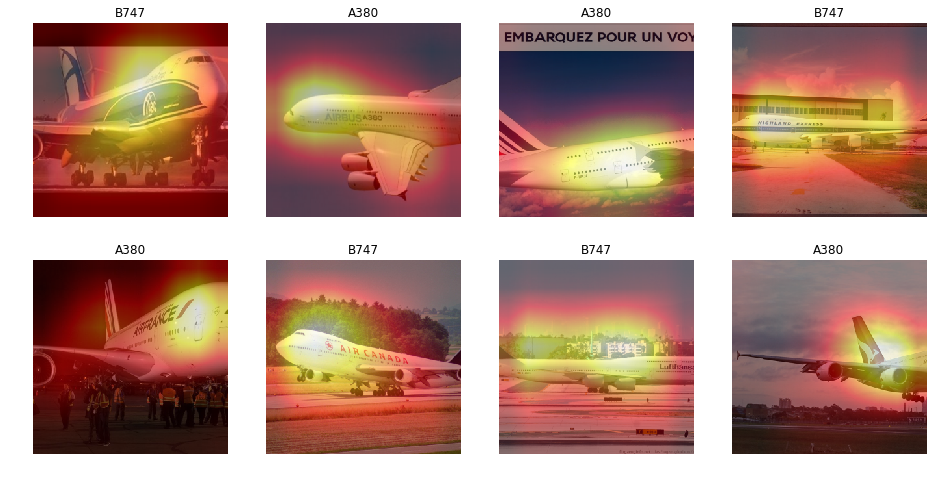

In [15]:
# We ask to display the image of the first 6 batches
for i in range(6):
    x, y = next(iter(data.val_dl))
    show_CAM(cam_model, x, classes)

## Done !
It's interresting to see that sometimes the model focus only on a mall area like a door to make the prediction and not on the whole plane like a human will do.
And that for the B747 it focus on the slope behind the fisrt floor like a human do as it is a strong feature of the B747.